# 1. Business Understanding

# 2. Data Mining

In [282]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

sns.set()

df = pd.read_csv("King_County_House_prices_dataset.csv")


In [232]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# 3. Data Cleaning

In [233]:
df.isnull().sum().sort_values(ascending=False)

yr_renovated     3842
waterfront       2376
view               63
sqft_lot15          0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
condition           0
sqft_living15       0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
zipcode             0
lat                 0
long                0
id                  0
dtype: int64

What to predict: 
* price

What to ignore:
* id, date,

What to maybe ignore:
* lat,long, zip code
* view(has been viewed?)
* year renovated (many missing)

In [236]:
df_clean = df.drop(["id","date","lat","long","zipcode","view", "yr_renovated"], axis = 1)


In [237]:
df_clean.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,1955,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,1800,7503


In [238]:
df_clean.isnull().sum().sort_values(ascending=False)

waterfront       2376
sqft_lot15          0
sqft_living15       0
yr_built            0
sqft_basement       0
sqft_above          0
grade               0
condition           0
floors              0
sqft_lot            0
sqft_living         0
bathrooms           0
bedrooms            0
price               0
dtype: int64

data categorical:
grade,condition,floors,watefront

sqft_basement (has to be repaired)

In [239]:
df_wo_cat = df_clean.drop(["grade","condition","floors","waterfront", "sqft_basement"], axis = 1)

In [242]:
y = df_wo_cat.price
X_train, X_test, y_train, y_test = train_test_split(df_wo_cat, y, test_size=0.2)

# 4. Data Exploration

(0, 9)

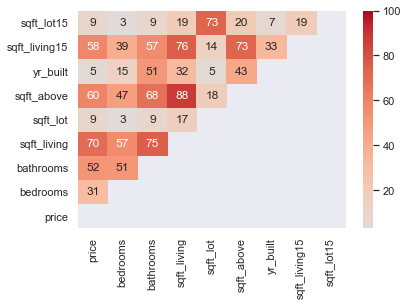

In [243]:
mask = np.triu(X_train.corr())
ax = sns.heatmap(round(X_train.corr()*100)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm'
                 ,center=0)
ax.set_ylim((0,9))
ax.set_xlim((0,9))

correlated with price:
* sqft above
* sqft living 15
* sqft living
* bathrooms
* bedrooms

autocorrelated:
* sqft_lot 15 with sqft_lot
* sqft_living with sqft_above and sqft_living and sqft_living 15

=> sqft_living, bathrooms, maybe bedrooms

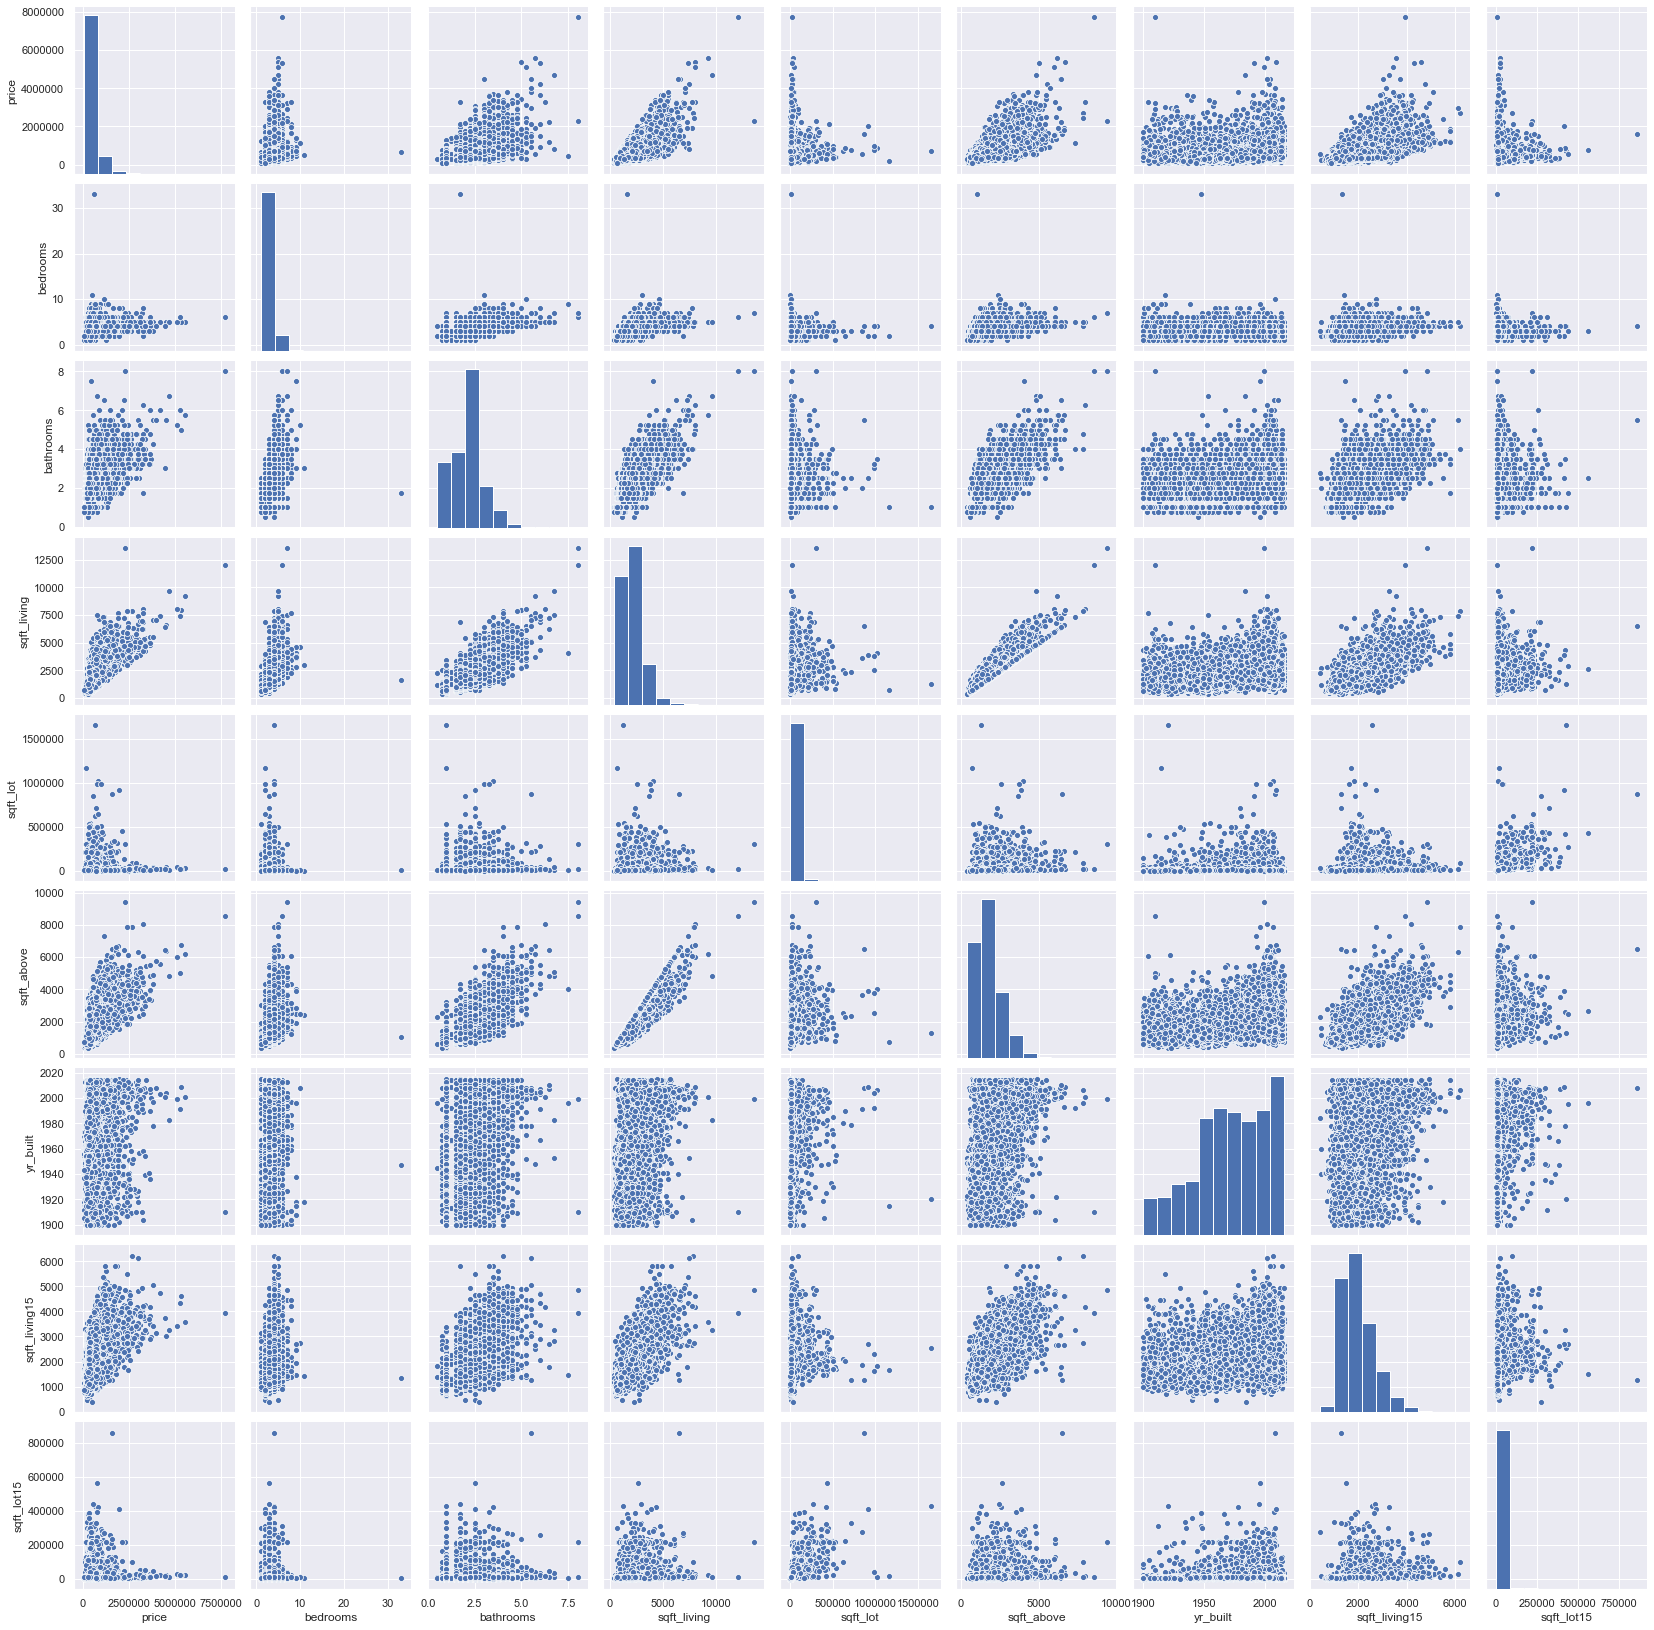

In [244]:
sns.pairplot(X_train);

Interesting features:
* bathrooms
* sqft_living
* sqft_above

Maybe:
* sqft living 15

# 5. Feature Engineering

# 6. Predictive Modeling

## 6.1. "Top Down" Methode

In [297]:
formula = "price ~ "
cols = list(X_train.columns)
cols.pop(cols.index("price"))
for i in cols:
    formula += i + " " + "+" + " "

# remove sqft_lot from formula, p >= 0.05

smf.ols(formula=formula.strip(" + "), data=X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     2756.
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:27:38   Log-Likelihood:            -2.3866e+05
No. Observations:               17277   AIC:                         4.773e+05
Df Residuals:                   17268   BIC:                         4.774e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.453e+06    1.5e+05     42.961      0.000    6.16e+06    6.75e+06
bedrooms      -6.425e+04   2454.747    -26.174      0.000   -6.91e+04   -5.94e+04
bathrooms      8.396e+04   4114.323     20.406      0.000    7.59e+04     9.2e+04
sqft_living     236.2485      5.348     44.177      0.000     225.766     246.731
sqft_lot          0.0307      0.063      0.485      0.628      -0.093       0.155
sqft_above       18.3579      4.974      3.691      0.000       8.609      28.107
yr_built      -3330.2892     77.682    -42.871      0.000   -3482.554   -3178.025
sqft_living15    87.9531      4.238     20.752      0.000      79.646      96.261
sqft_lot15       -0.7931      0.099     -7.981      0.000      -0.988      -0.598
==============================================================================
Omnibus:                    11549.779   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           392666.979
Skew:                           2.738   Prob(JB):                         0.00
Kurtosis:                      25.704   Cond. No.                     4.20e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.2e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [298]:
formula = "price ~ "
#cols = list(df_wo_cat.columns)
cols.pop(cols.index("sqft_lot"))
cols.pop(cols.index("sqft_above"))
cols.pop(cols.index("bedrooms"))
for i in cols:
    formula += i + " " + "+" + " "

# remove sqft_lot from formula, p >= 0.05
# remove sqft_above because of collinearity
# remove bedrooms cause coefficient < 0

smf.ols(formula=formula.strip(" + "), data=X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     4101.
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:27:39   Log-Likelihood:            -2.3901e+05
No. Observations:               17277   AIC:                         4.780e+05
Df Residuals:                   17271   BIC:                         4.781e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.786e+06   1.45e+05     39.792      0.000     5.5e+06    6.07e+06
bathrooms      6.519e+04   4134.235     15.768      0.000    5.71e+04    7.33e+04
sqft_living     216.6999      4.003     54.134      0.000     208.854     224.546
yr_built      -3054.3275     75.505    -40.452      0.000   -3202.325   -2906.330
sqft_living15    97.1020      4.237     22.917      0.000      88.797     105.407
sqft_lot15       -0.6035      0.071     -8.521      0.000      -0.742      -0.465
==============================================================================
Omnibus:                    11969.047   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           445662.657
Skew:                           2.859   Prob(JB):                         0.00
Kurtosis:                      27.216   Cond. No.                     2.33e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

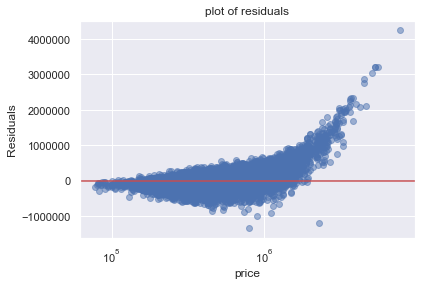

In [299]:
plt.scatter(x=X_train.price, y=smf.ols(formula=formula.strip(" + "), data=X_train).fit().resid, alpha = 0.5)
plt.title("plot of residuals")
plt.axhline(color='r')
plt.ylabel("Residuals")
plt.xlabel("price")
plt.xscale("log");

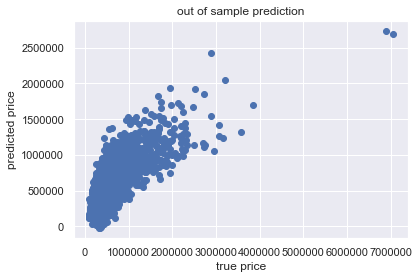

In [300]:

y_pred = smf.ols(formula=formula.strip(" + "), data=X_train).fit().predict(X_test)
plt.scatter(x=y_test, y=y_pred)
plt.ylabel("predicted price")
plt.xlabel("true price")
plt.title("out of sample prediction");

In [301]:
print("Mean Squared Error (less is better):" + str(mean_squared_error(y_test, y_pred)))
print("R2 score (closer to 1 is better):" + str(r2_score(y_test, y_pred)))

Mean Squared Error (less is better):63596892460.33626
R2 score (closer to 1 is better):0.5563261702317475


## 6.2. Ausgewählte Variablen

In [302]:
# Aus correlation matrix und pairplots: bathrooms und sqft_living
smf.ols(formula="price ~ sqft_living + sqft_above + sqft_living15", data=X_train_wo_cat).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     5541.
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:27:42   Log-Likelihood:            -2.2482e+05
No. Observations:               16197   AIC:                         4.496e+05
Df Residuals:                   16193   BIC:                         4.497e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.017e+05   6198.814    -16.402      0.000   -1.14e+05   -8.95e+04
sqft_living     269.4958      4.889     55.127      0.000     259.914     279.078
sqft_above      -40.3803      5.215     -7.743      0.000     -50.603     -30.158
sqft_living15    76.9541      4.668     16.487      0.000      67.805      86.103
==============================================================================
Omnibus:                    12068.081   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           627234.615
Skew:                           3.077   Prob(JB):                         0.00
Kurtosis:                      32.859   Cond. No.                     1.11e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

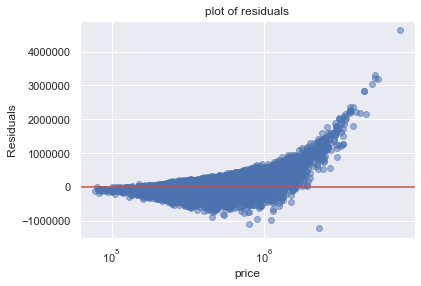

In [303]:
plt.scatter(x=X_train.price, y=smf.ols(formula="price ~ sqft_living + sqft_above + sqft_living15", data=X_train).fit().resid, alpha = 0.5)
plt.title("plot of residuals")
plt.axhline(color='r')
plt.ylabel("Residuals")
plt.xlabel("price")
plt.xscale("log");

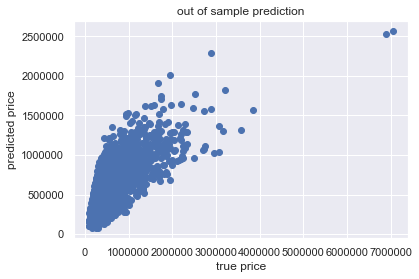

In [304]:
y_pred = smf.ols(formula="price ~ sqft_living + sqft_above + sqft_living15", data=X_train).fit().predict(X_test)

plt.scatter(x=y_test, y=y_pred)
plt.ylabel("predicted price")
plt.xlabel("true price")
plt.title("out of sample prediction");

In [305]:
print("Mean Squared Error (less is better):" + str(mean_squared_error(y_test, y_pred)))
print("R2 score (closer to 1 is better):" + str(r2_score(y_test, y_pred)))

Mean Squared Error (less is better):70095367240.2796
R2 score (closer to 1 is better):0.5109905715612929


# 7. Visualization

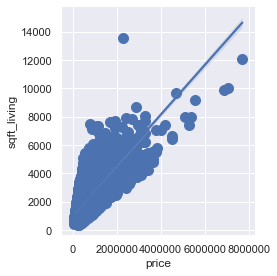

In [89]:
sns.lmplot(x="price", y="sqft_living", data=df_wo_cat, palette="muted", height=4, scatter_kws={"s": 100, "alpha": 1});

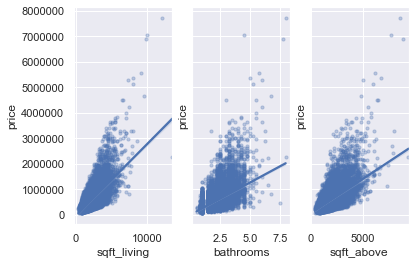

In [128]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, squeeze = True, sharey=True)
sns.regplot(x="sqft_living", y="price", data=df_wo_cat, scatter_kws={"s": 10, "alpha": 0.3}, ax=ax1)
sns.regplot(x="bathrooms", y="price", data=df_wo_cat, scatter_kws={"s": 10, "alpha": 0.3}, ax=ax2)
sns.regplot(x="sqft_above", y="price", data=df_wo_cat, scatter_kws={"s": 10, "alpha": 0.3}, ax=ax3)
#sns.regplot(x="price", y="sqft_above", data=df_wo_cat, scatter_kws={"s": 100, "alpha": 0.3}, ax=ax2)

# A. Summary

# B. Future Work

In [ ]:
# wieviel weichen unsere prognosen prozentual von den jeweiligen tatsächlichen preisen ab?